In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

RANDOM_STATE = 42

In [2]:
df = pd.read_csv('processed_data.csv')

In [3]:
Q1 = df["price"].quantile(0.25)
Q3 = df["price"].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
df = df[(df["price"] >= lower_bound) & (df["price"] <= upper_bound)]


X = df.drop(columns=["price"])
y = df["price"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [4]:
X = df.drop('price', axis=1)
y = df['price']




X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=RANDOM_STATE, shuffle=True)

In [5]:
numerical_features = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X_train.select_dtypes(include=['object']).columns.tolist()


preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

In [6]:
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=50, random_state=42))
])


model.fit(X_train, y_train)

y_pred = model.predict(X_test)


mse = mean_squared_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.4f}")
print(f"MSE: {mse:.2f}")

RMSE: 323540.64
R²: 0.9287
MSE: 104678543611.87


In [7]:
df["power_to_capacity"] = df["engine_power"] / df["engine_capacity"]


from xgboost import XGBRegressor

model_xgb = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42))
])


from sklearn.model_selection import GridSearchCV

param_grid = {
    'regressor__n_estimators': [50, 100],
    'regressor__max_depth': [3, 5, 7]
}

grid_search = GridSearchCV(model_xgb, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_

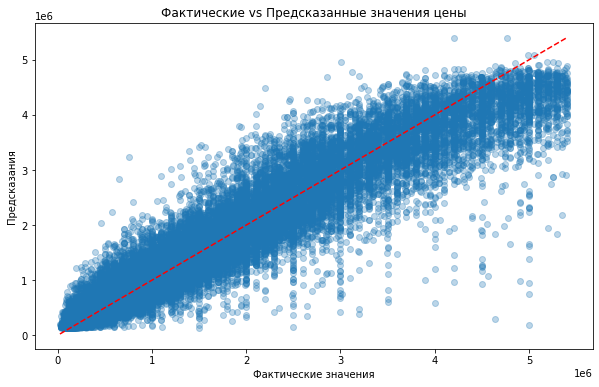

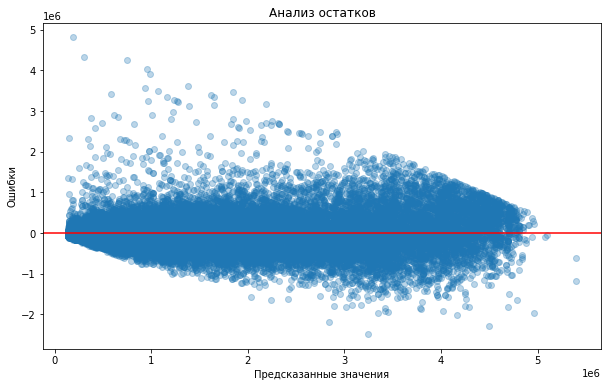

In [8]:
test_predictions = best_model.predict(X_test)


import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(y_test, test_predictions, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Фактические значения')
plt.ylabel('Предсказания')
plt.title('Фактические vs Предсказанные значения цены')
plt.show()


residuals = y_test - test_predictions
plt.figure(figsize=(10, 6))
plt.scatter(test_predictions, residuals, alpha=0.3)
plt.axhline(y=0, color='r', linestyle='-')
plt.xlabel('Предсказанные значения')
plt.ylabel('Ошибки')
plt.title('Анализ остатков')
plt.show()